In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os

# Camera Calibration

In this section, the following tasks are performed
- Perform camera calibration on provided calibration images.
- Create a utility function undistortImage using the resultant correction matrix.
- Verify the performance of the function with test image(s).

### calculate distortion correction matrix

In [2]:
# number of inside corners of checker board
nx = 9
ny = 6

#import all images
images = glob.glob("camera_cal/calibration*.jpg")

#prepare object points 
objpts = np.zeros((ny*nx,3),np.float32)
objpts[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

obj_points =[]
img_points =[]

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray,(nx,ny),None)
    
    if ret == True:
        img_points.append(corners)
        obj_points.append(objpts)
        
        print(fname,"find corners successful")
        '''
        cv2.drawChessboardCorners(img,(nx,ny),corners,ret)
        print(fname)
        plt.imshow(img)
        plt.show()
        '''

    else:
        print(fname,"failed to find corners")
        
ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(obj_points,img_points,gray.shape[::-1],None,None)

print("mtx =",mtx)
print("dist =",dist)


camera_cal\calibration1.jpg failed to find corners
camera_cal\calibration10.jpg find corners successful
camera_cal\calibration11.jpg find corners successful
camera_cal\calibration12.jpg find corners successful
camera_cal\calibration13.jpg find corners successful
camera_cal\calibration14.jpg find corners successful
camera_cal\calibration15.jpg find corners successful
camera_cal\calibration16.jpg find corners successful
camera_cal\calibration17.jpg find corners successful
camera_cal\calibration18.jpg find corners successful
camera_cal\calibration19.jpg find corners successful
camera_cal\calibration2.jpg find corners successful
camera_cal\calibration20.jpg find corners successful
camera_cal\calibration3.jpg find corners successful
camera_cal\calibration4.jpg failed to find corners
camera_cal\calibration5.jpg failed to find corners
camera_cal\calibration6.jpg find corners successful
camera_cal\calibration7.jpg find corners successful
camera_cal\calibration8.jpg find corners successful
came

### create utility funtion

In [3]:
def undistortImage(img):
    '''
    call cv2.undistort with calibration results
    '''
    return cv2.undistort(img,mtx,dist,None,mtx)

### verify performance

Test the utility function on a chessboard image and a road image.

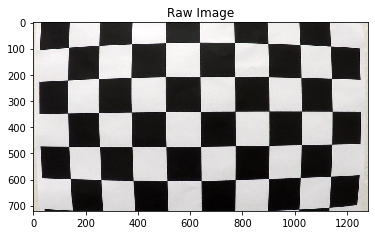

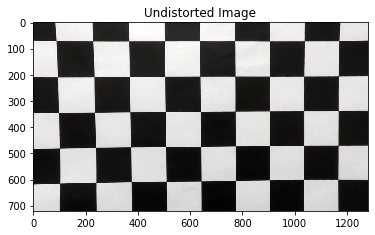

In [4]:
# test on calibration1.jpg
img = mpimg.imread("camera_cal/calibration1.jpg")

plt.imshow(img)
plt.title('Raw Image')
plt.savefig('output_images/cam_cal_raw.png')
plt.show()

undst_img = undistortImage(img)

plt.imshow(undst_img)
plt.title('Undistorted Image')
plt.savefig('output_images/cam_cal_undistort.png')
plt.show()

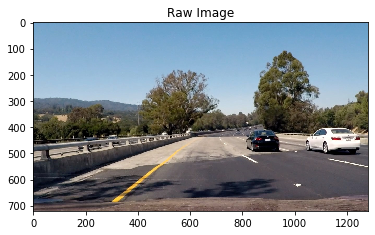

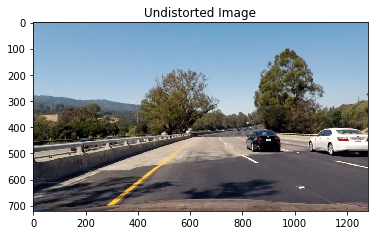

In [5]:
# test on test4.jpg
img = mpimg.imread("test_images/test4.jpg")

plt.imshow(img)
plt.title('Raw Image')
plt.savefig('output_images/test_raw.png')
plt.show()

undst_img = undistortImage(img)

plt.imshow(undst_img)
plt.title('Undistorted Image')
plt.savefig('output_images/test_undistort.png')
plt.show()

# Color / Gradient Filter

Create a filtering funtion that combines gradient threshold and saturation threshold.

Use a test image to show effect of individual components. 

In [6]:
def applyThreshold(img, visualize=False):
    '''
    apply color and gradient threshold to a 3 channel image
    return filtered binary image
    '''
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold X gradient
    x_thresh_min = 20 #20
    x_thresh_max = 255
    
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= x_thresh_min) & (scaled_sobel <= x_thresh_max)] = 1

    if visualize is True:
        plt.imshow(sxbinary, cmap='gray')
        plt.title('X Gradient Threshold')
        plt.show()
    
    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255

    s_binary = np.zeros_like(s_channel)

    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    if visualize is True:
        plt.imshow(s_binary, cmap='gray')
        plt.title('Saturation Threshold')
        plt.show()

    # Combined
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    if visualize is True:
        plt.imshow(combined_binary, cmap='gray')
        plt.title('Combined Threshold')
        plt.show()
    

    return combined_binary

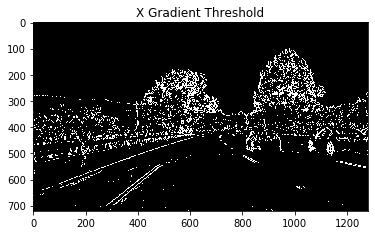

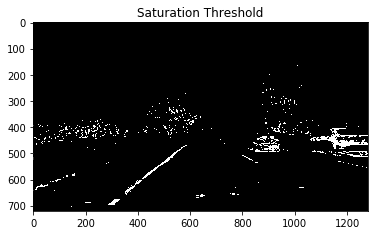

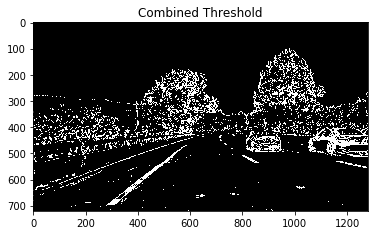

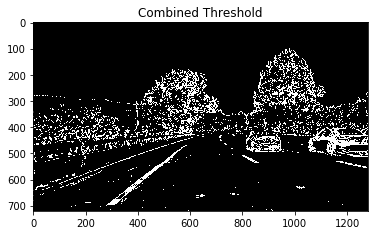

In [7]:
img = mpimg.imread("test_images/test4.jpg")
img = undistortImage(img)
img = applyThreshold(img,visualize=True)

plt.imshow(img, cmap='gray')
plt.title('Combined Threshold')
plt.savefig('output_images/test_threshold.png')
plt.show()

# Perspective Transform

In this section, the following tasks are performed
- Use one straight line image as reference to prepar perspective transform matrices.
- Create utility funtion warpImage with the resultant transformation matrices.
- Create utility funtion unwarpImage with the resultant transformation matrices.
- Use second straight line image to verify.

### calculate transformation matrices

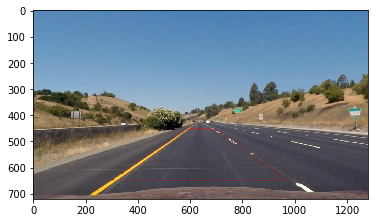

M = [[-5.64315353e-01 -1.54024896e+00  1.00116183e+03]
 [-5.55111512e-15 -1.79253112e+00  7.98340249e+02]
 [-9.54097912e-18 -2.40663900e-03  1.00000000e+00]]
Minv = [[ 1.27314815e-01 -8.59259259e-01  5.58518519e+02]
 [-2.22044605e-15 -5.57870370e-01  4.45370370e+02]
 [-3.46944695e-18 -1.34259259e-03  1.00000000e+00]]


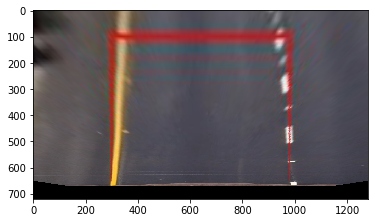

In [9]:
img_st1 = cv2.imread("test_images/straight_lines1.jpg")
img_st1 = undistortImage(img_st1)

# Identify 2 points on the left lane line
left_top = [590,450]
left_bot = [300,650]
# Mirror the points to the right lane line with the assumption the image is taken with vehicle centered in the lane
right_top = [(img_st1.shape[1] - left_top[0]),left_top[1]]
right_bot = [(img_st1.shape[1] - left_bot[0]),left_bot[1]]

pts = np.array([left_top,left_bot,right_bot,right_top], np.int32)
pts = pts.reshape((-1,1,2))
img = cv2.polylines(img_st1,[pts],True,(0,0,255))
ret = cv2.imwrite("output_images/straight_box_cv.jpg",img_st1)


# Load as mpimg for plotting
img_st1 = mpimg.imread("output_images/straight_box_cv.jpg")
plt.figure()
plt.imshow(img_st1)
plt.savefig('output_images/straight_with_box.png')
plt.show()

src = np.float32([left_top,left_bot,right_bot,right_top])
dst = np.float32(
    [[300,100],
     left_bot,
     right_bot,
     [right_bot[0],100]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

print("M =",M)
print("Minv =",Minv)

warped = cv2.warpPerspective(img_st1, M, (img_st1.shape[1],img_st1.shape[0]), flags=cv2.INTER_LINEAR)

plt.figure()
plt.imshow(warped)
plt.savefig('output_images/straight_with_box_warped.png')
plt.show()

### create utility funtion

In [10]:
def warpImage(img):
    '''
    call cv2.warpPerspective with parameters calculated with test image
    tranform image from camera view to bird eye view
    '''
    img_size = (img.shape[1],img.shape[0])
    
    return cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

def unwarpImage(img):
    '''
    call cv2.warpPerspective with parameters calculated with test image
    tranform image from bird eye view to camera view
    '''
    img_size = (img.shape[1],img.shape[0])
    
    return cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)

### verify performance

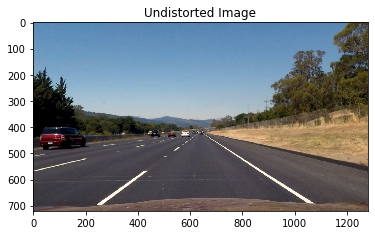

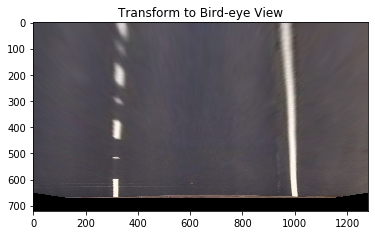

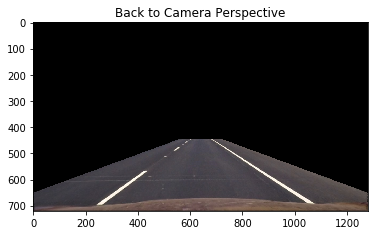

In [11]:
img_st2 = mpimg.imread("test_images/straight_lines2.jpg")
img_st2 = undistortImage(img_st2)
# show undistored image from camera perspective
plt.imshow(img_st2)
plt.title('Undistorted Image')
plt.savefig('output_images/straight_lines2_undistort.png')
plt.show()

# perspective transformed to bird eye view
img_st2_birdeye = warpImage(img_st2)
plt.imshow(img_st2_birdeye)
plt.title('Transform to Bird-eye View')
plt.savefig('output_images/straight_lines2_warped.png')
plt.show()

# transform back to camera perspective
img_st2 = unwarpImage(img_st2_birdeye)
plt.imshow(img_st2)
plt.title('Back to Camera Perspective')
plt.savefig('output_images/straight_lines2_unwarped.png')
plt.show()

# Pixel to World Conversion

- typical US highway lane is 12 feet wide
- typical US highway lane line marker is 10 feet long

With the perspective transformed view of a straight line image, we can get some rough conversion factors meter_per_pixel_y and meter_per_pixel_x to be used to calculate the radius of curvature in real world.

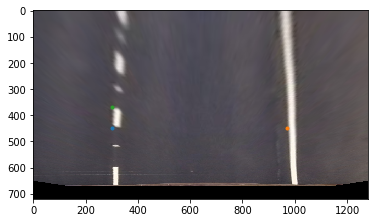

0.005459104477611941 0.0381


In [12]:
plt.imshow(img_st2_birdeye)

# Identify 3 points to measure the width of lane and lenght of lane marker in pixels
p1 = [300,450]
p2 = [970,p1[1]]
p3 = [p1[0],370]

plt.plot(p1[0],p1[1],'.')
plt.plot(p2[0],p2[1],'.')
plt.plot(p3[0],p3[1],'.')

plt.savefig('output_images/measure_lane_width.png')
plt.show()

#Calculate aspect ratio
meter_per_pixel_x = 12 * 0.3048 / (p2[0] - p1[0]) 
meter_per_pixel_y = 10 * 0.3048 / (p1[1] - p3[1])

print(meter_per_pixel_x,meter_per_pixel_y)

# Region of Interest

Define a region of interest. Start with the simplest masking by only taking the bottom half of the image.

In [ ]:
def regionInterest(img):
    """
    Ignore top half of the image
    """
    region = np.zeros_like(img)
    region[400:,:] = img[400:,:]
    
    return region


## Process Image

In [ ]:
raw_img = mpimg.imread("test_images/test5.jpg")
img = undistortImage(raw_img)
img = applyThreshold(img)
img = regionInterest(img)
binary_warped = warpImage(img)
 
plt.imshow(binary_warped, cmap='gray')
plt.show()


# Detect Lane

## Tracking

As recommended by the project instruction, a Line() class is here defined and used to keep track of all the interesting parameters measure from frame to frame. An instance for left and right lane lines are then declared respectively.


In [ ]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        
        # parameter n
        self.n = 4
        
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
        #x values for detected line pixels
        self.allx = None  
        
        #y values for detected line pixels
        self.ally = None

        #x values for plotting
        self.plotx = None
        
        #y values for plotting
        self.ploty = None
        
        
    def fit_poly(self, img_shape):
        # Fit a second order polynomial to the pixels np.polyfit()
        self.current_fit = np.polyfit(self.ally, self.allx, 2)
        
        
        #ToDo: figure out ways to set confidence by sanity check
        confidence = 5
        
        # sanity check 1: change in coefficient 
        if self.detected == True:
            self.diffs = self.current_fit - self.best_fit
        
        # sanity check 2:
        
        
        # if confidence level ok
        if confidence >= 3:
            self.detected = True
        else:
            self.detected = False
        
        # Generate y values for plotting
        self.ploty = np.linspace(0, img_shape[0]-1, img_shape[0])

        temp_x = self.current_fit[0]*self.ploty**2 + self.current_fit[1]*self.ploty + self.current_fit[2]
            
        # keep only recent n iterations
        if len(self.recent_xfitted) >= self.n:
            del self.recent_xfitted[0]
                
        self.recent_xfitted.append(temp_x)
        

        self.UpdateAverageLine()

    def UpdateAverageLine(self):
        available_iteration = len(self.recent_xfitted)
        if available_iteration != 0:
            fit_size = len(self.recent_xfitted[0])
            # reset best fit
            self.bestx = [0] * fit_size
        
            for j in range(fit_size):
                for i in range(available_iteration):
                    self.bestx[j] += self.recent_xfitted[i][j]
                self.bestx[j] /= len(self.recent_xfitted)
        
        # Fit a second order polynomial to all the points from past n iterations
        self.best_fit = np.polyfit(self.ploty, self.bestx, 2)    
        
        self.plotx = self.best_fit[0]*self.ploty**2 + self.best_fit[1]*self.ploty + self.best_fit[2]        
            
    
    def UpdateRadius(self):
        # Use plotting points instead of raw pixel points to calculate radius curvature
        x = self.plotx * meter_per_pixel_x
        y = self.ploty * meter_per_pixel_y
        
        coeff = np.polyfit(y, x, 2)
        y_eval = y[-1]
        R = ((2.0 * coeff[0] * y_eval + coeff[1])**2 + 1.0)**(3.0/2.0)
        R = R / (2.0 * np.absolute(coeff[0]) )
        
        self.radius_of_curvature = R
    
    def UpdateOffset(self,img_shape):
        self.line_base_pos = (self.plotx[-1] - img_shape[1]/2)*meter_per_pixel_x

# The Pipeline

A pipeline function ProcessImage is defined to update the left and right lane line object given an image (or a frame from video)

In [ ]:
# create lane line objects

LeftLine = Line()
RightLine = Line()


In [ ]:
def bottomHalfHist(img):
    bottom_half = img[img.shape[0]//2:,:]
    
    histogram = np.sum(bottom_half,axis=0)
    
    return histogram


In [ ]:
# example of histogram plot 

histogram = bottomHalfHist(binary_warped)
plt.plot(histogram)
plt.show()


In [ ]:
def slidingWindow(binary_warped):
    
    histogram = bottomHalfHist(binary_warped)

    midpoint = np.int(histogram.shape[0]//2)

    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:])+midpoint

    # sliding window parameters
    nwindows = 9
    margin = 50
    minpix = 50

    window_height = np.int(binary_warped.shape[0]//nwindows)

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Create an output image for visualization
    out_img = np.dstack((binary_warped,binary_warped,binary_warped))

    # Step through the windows one by one
    for window in range(nwindows):
    
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
    
        # Find the four below boundaries of the window
        win_xleft_low = np.int(leftx_current - margin)
        win_xleft_high = np.int(leftx_current + margin)
        win_xright_low = np.int(rightx_current - margin)
        win_xright_high = np.int(rightx_current + margin)
    
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy>win_y_low)&(nonzeroy<win_y_high)
                          &(nonzerox>win_xleft_low)&(nonzerox<win_xleft_high)).nonzero()[0]
    
        good_right_inds = ((nonzeroy>win_y_low)&(nonzeroy<win_y_high)
                           &(nonzerox>win_xright_low)&(nonzerox<win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window
        #(`right` or `leftx_current`) on their mean position
        if  len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    
        if  len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # update line objects
    LeftLine.allx = leftx
    LeftLine.ally = lefty
    
    RightLine.allx = rightx
    RightLine.ally = righty


In [ ]:
def searchNearby(binary_warped):
    # this function searches the near region of previous detect lane lines for pixel 
    margin = 100

    # Set the area of search based on activated x-values
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_fit = LeftLine.best_fit
    right_fit = RightLine.best_fit
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # update line objects
    LeftLine.allx = leftx
    LeftLine.ally = lefty
    
    RightLine.allx = rightx
    RightLine.ally = righty


In [ ]:
def ProcessImage(raw_image,display=False, save=False):

    undist = undistortImage(raw_image)
    img = applyThreshold(undist)
    img = regionInterest(img)
    
    if display:
        plt.imshow(img, cmap='gray')
        plt.show()
    
    binary_warped = warpImage(img)
    
    if display:
        plt.imshow(binary_warped, cmap='gray')
        if save:
            plt.savefig('output_images/test_binary_warp.png')
        plt.show()
    
    method = 'None' # debug trace which method used for detecting lines
    
    if LeftLine.detected == True and RightLine.detected == True:
        searchNearby(binary_warped)
    
        LeftLine.fit_poly(binary_warped.shape)
    
        RightLine.fit_poly(binary_warped.shape)
        
        method = 'Search Near'
        
    if LeftLine.detected == False or  RightLine.detected == False:
        slidingWindow(binary_warped)
    
        LeftLine.fit_poly(binary_warped.shape)
    
        RightLine.fit_poly(binary_warped.shape)
        method = 'Sliding Win'       
    
    # Calculate radius of curvature
    LeftLine.UpdateRadius()
    RightLine.UpdateRadius()

    # Calculate off-center
    LeftLine.UpdateOffset(binary_warped.shape)
    RightLine.UpdateOffset(binary_warped.shape)
    
    offset = (LeftLine.line_base_pos + RightLine.line_base_pos) /2

    # Visualize lane detection for debugging
    if display:
        out_img = np.dstack((binary_warped,binary_warped,binary_warped))
        out_img[LeftLine.ally, LeftLine.allx] = [255, 0, 0]
        out_img[RightLine.ally, RightLine.allx] = [0, 0, 255]

        plt.plot(LeftLine.plotx, LeftLine.ploty, color='yellow')
        plt.plot(RightLine.plotx, RightLine.ploty, color='yellow')
    
        plt.imshow(out_img)
        if save:
            plt.savefig('output_images/test_pixel_fit.png')
        
        plt.show()
    
    ## Project the lane to the camera image 
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([LeftLine.plotx, LeftLine.ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([RightLine.plotx, RightLine.ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0) # project to the undistorted image

    
    # Write Information on Image
    text = ["Radius of Curvature Left = %d m" % LeftLine.radius_of_curvature,
            "Radius of Curvature Right = %d m" % RightLine.radius_of_curvature,
            "Host Vehicle is Off-Center by %.2f m" % offset,
            #method,
            #"num of left pix = %d" % len(LeftLine.ally),
            #"num of right pix = %d" % len(RightLine.ally)
           ]
    
    font = cv2.FONT_HERSHEY_SIMPLEX 
    org = (100, 100)
    fontScale = 1
    color = (255, 255, 255) 
    thickness = 3
    
    for txt in text: 
        result = cv2.putText(result, txt, org, font, fontScale,  
                     color, thickness, cv2.LINE_AA, False) 
        org = (100, org[1]+100) 
   
    return result

## Test the Pipeline on Static Image

In [ ]:
img = mpimg.imread("test_images/test4.jpg")

LeftLine = Line()
RightLine = Line()

result = ProcessImage(img, display=True, save= True)

plt.imshow(result)
plt.savefig('output_images/test_project_lane.png')
plt.show()


## Test on Several Frames of Video

A debugging step that fast forwards to a problematic frame.

In [ ]:
time = 41.6

vidcap = cv2.VideoCapture('project_video.mp4')

fps = vidcap.get(cv2.CAP_PROP_FPS)

frame_number = round(time*fps)

vidcap.set(1, frame_number-1)

success,image = vidcap.read()

image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.show()

LeftLine = Line()
RightLine = Line()

result = ProcessImage(image,display=True)

plt.imshow(result)
plt.show()

# Process Video

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
LeftLine = Line()
RightLine = Line()

output_video = 'project_video_output.mp4'

clip0 = VideoFileClip("project_video.mp4").subclip(0,4)
clip1 = VideoFileClip("project_video.mp4").subclip(0,20)
clip2 = VideoFileClip("project_video.mp4").subclip(20,30)
clip3 = VideoFileClip("project_video.mp4").subclip(30,38)
clip4 = VideoFileClip("project_video.mp4").subclip(38,45)
clip5 = VideoFileClip("project_video.mp4").subclip(45,50)
wholevideo = VideoFileClip("project_video.mp4")
video_clip = wholevideo.fl_image(ProcessImage) #NOTE: this function expects color images!!
%time video_clip.write_videofile(output_video, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))